In [183]:
Record = ST_mean

In [191]:
6.88 / 0.1 ** (5/3)

319.3413117525592

In [193]:
6.88 / 0.046687983005432386

147.36125994561547

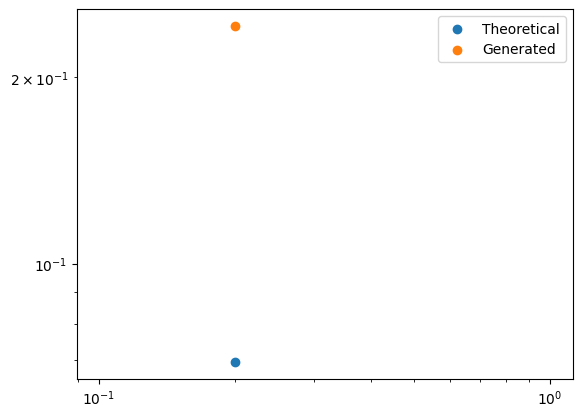

In [51]:
plt.scatter(d_r_0, D_r_0,label='Theoretical')
plt.scatter(d_r_0, RMSWhole, label='Generated')
plt.xscale('log')
plt.yscale('log')
plt.legend()

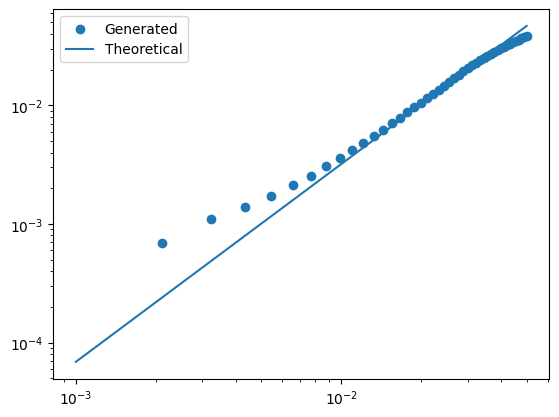

In [195]:
plt.figure()
plt.scatter(rStruct, ST_mean, label='Generated')
plt.plot(rStruct, 147.36125994561547 * Structure0, label='Theoretical')
plt.xscale('log')
plt.yscale('log')
plt.legend()





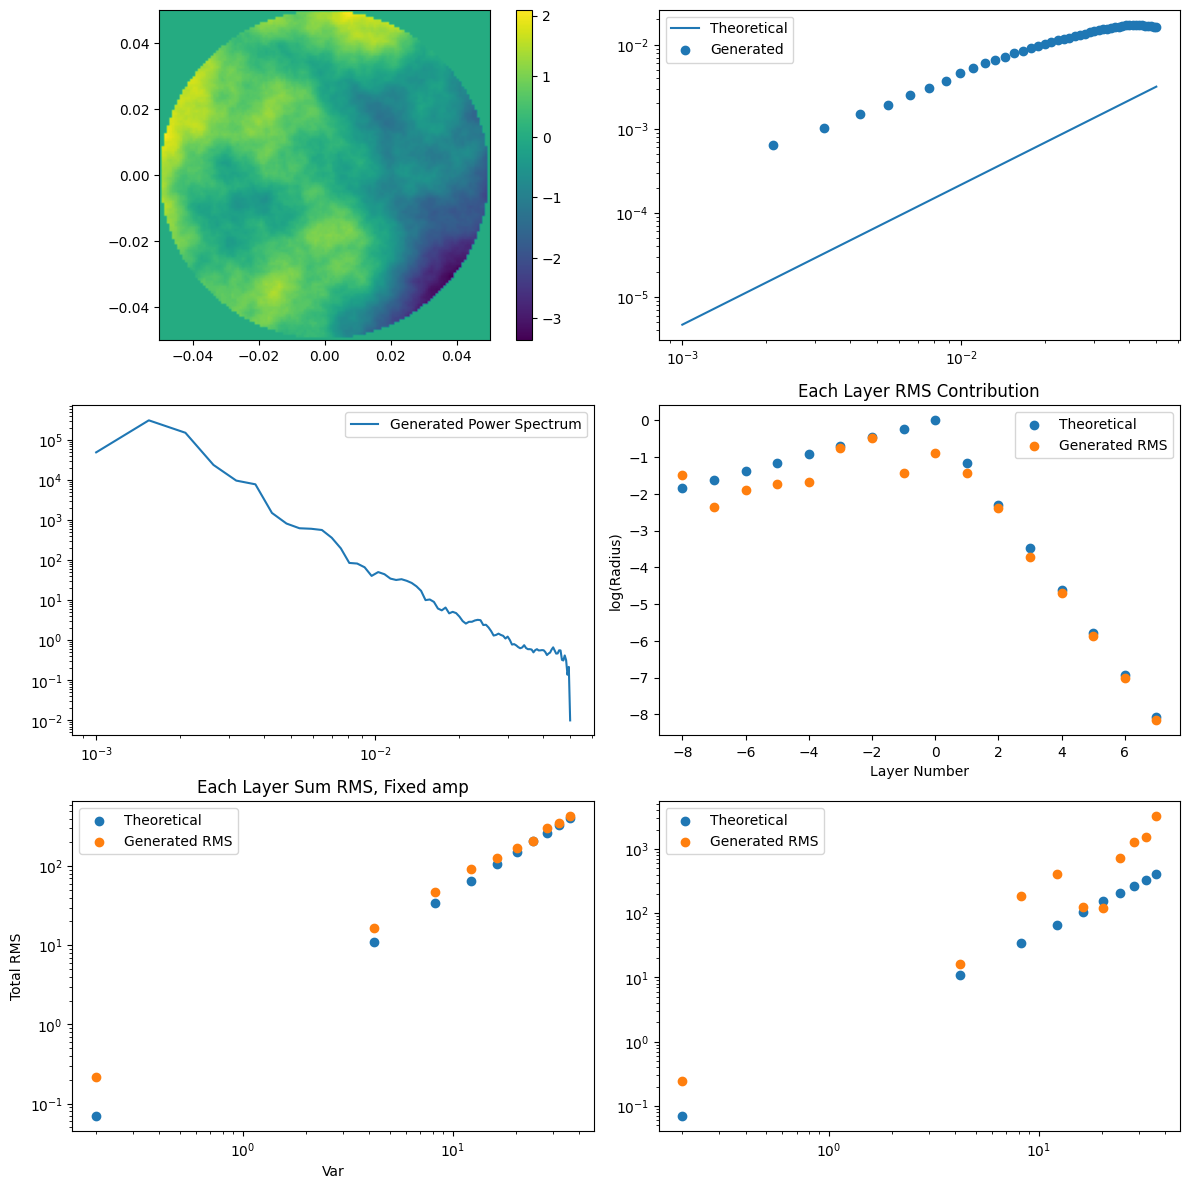

In [2]:
%reset -f
import numpy as np
import opensimplex as os
import matplotlib.pyplot as plt
import matplotlib.animation
import cProfile
import time

# Simulation Size and Parameter
class Sys:
    def __init__(self):
        self.Size = 128
        self.Radius = 0.05
        self.Number = 1
        self.Layer = 8
        self.Radius_max = 2
        self.r_0 = 0.1
        self.d_r_0 = 1
        self.amp = 5.6
        self.default_num = 10
        self.l = 2.0
        self.p = self.l ** (5.0/6.0)
        self.s = 1
        self.i = np.arange(-self.Layer, self.Layer)
        self.ls = self.l ** self.i
        self.ps = self.p ** self.i
        self.rms = 1/self.ps ** 2
        self.rms[self.i < 0] *= self.ls[self.i < 0] ** 2
        
    def __repr__(self):
        return (
            f"Sys(Size={self.Size}, Radius={self.Radius}, Number={self.Number}, "
            f"Layer={self.Layer}, Radius_max={self.Radius_max}, r_0={self.r_0}, "
            f"d_r_0={self.d_r_0}, amp={self.amp}, default_num={self.default_num}, "
            f"l={self.l}, p={self.p}, s={self.s}, i={self.i}, ls={self.ls}, "
            f"ps={self.ps}, rms={self.rms})"
        )

# Main Noise (Fixed Radius)
def Noise2Gen(sys):
    Radius = sys.Radius
    Size = sys.Size
    r_0 = sys.r_0
    
    x = np.linspace(-0.5, 0.5, Size)
    y = x
    X, Y = np.meshgrid(x, y)
    circ = np.sqrt(X ** 2 + Y ** 2) < 0.5
    
    # Parameter
    i = sys.i
    ls = sys.ls
    ps = sys.ps
    s = sys.s
    a = sys.amp
    rms = sys.rms
    
    # Noise Generation
    P_all = []
    PP = np.zeros((Size, Size))
    P = np.zeros((Size, Size))
    P_rms = np.zeros_like(i, dtype=np.float64)
    P_rms0 = np.zeros_like(i, dtype=np.float64)
    
    for j in i:
        P = a * os.noise2array(s * x * ls[j], s * (y + np.random.rand() * 10) * ls[j] + j * 6.05) * circ / ps[j]
        # P = a * os.noise2array(s * x * ls[j], s * y * ls[j] + j * 6.05) * circ / ps[j]
        P_rms[j] = np.var(P, where = circ)
        P_all.append(P)
    
    
    PP = np.sum(P_all, axis = 0)
    PP[circ] = PP[circ] - PP.mean(where=circ)
    
    # PP *= 1.015 * (2 * Radius / r_0) ** (5/3) / np.sum(rms)
    PP *= 1.03 * (2 * Radius / r_0) ** (5/6) / np.sqrt(np.sum(rms))
    P_rms *= 1.015 * (2 * Radius / r_0) ** (5/3) / np.sum(rms)
 
    return PP, P_rms, circ

# Power Spectrum, return the radial profile and radius
def NoisePowerSpectrum(P, Size):
    w = np.outer(np.blackman(Size), np.blackman(Size))
    Pfft = np.abs(np.fft.fftshift(np.fft.fft2(P * w))) ** 2
    
    Pfft_center = ((Size)/2, (Size)/2)
    row, col = Pfft.shape
    n, m = np.indices((row, col))
    r = np.sqrt((m - Pfft_center[1])**2 + (n - Pfft_center[0])**2)
    r = r.astype(np.int32)
    
    # Intensity Per Radius (Unit: 1)
    Pfft_meanr = np.bincount(r.ravel(), Pfft.ravel())
    nr = np.bincount(r.ravel())
    radial_profile = Pfft_meanr / nr
    
    return (radial_profile, r, nr)

# Structure Function
def StructrueFun(P, r, nr):
    P_meanr = np.bincount(r.ravel(), P.ravel())
    Nrefractive = P_meanr / nr
    max_lag = len(Nrefractive) // 2
    structure_func = np.zeros(max_lag)
    for l in range(1, max_lag):
        diff = np.abs(Nrefractive[l:] - Nrefractive[:-l]) ** 2
        structure_func[l] = np.mean(diff)
    return structure_func



# Noise, Power Spectrum
sys = Sys()

# For fixed Radius Calculation
Radius = sys.Radius
Size = sys.Size
Number = sys.Number
i = sys.i
l = sys.l
default_num = sys.default_num

start_time = time.time()
P0, P_RMS, circnull = Noise2Gen(sys)  # Primary Noise Generation for fixed radius
end_time = time.time()
noise_gen_time = end_time - start_time




start_time = time.time()
PowerSpec, r, nr = NoisePowerSpectrum(P0, Size)
end_time = time.time()
power_spec_time = end_time - start_time

StructF= StructrueFun(P0, r, nr)   # A possible time saving point

# Structure Function
ST = np.zeros(len(StructF))
start_time = time.time()
for mm in range(Number):
    StructF = np.zeros(len(StructF))
    P, RMSnull, circnull = Noise2Gen(sys)
    StructF = StructrueFun(P0, r, nr)
    ST += StructF
end_time = time.time()
struct_func_avg_time = (end_time - start_time) / Number

ST_mean = ST/Number


# Total RMS
Radius_max = sys.Radius_max
r_0 = sys.r_0
Radius_range = np.arange(0.01, Radius_max, 0.2)
d_r_0 = 2 * Radius_range/r_0
D_r_0 = d_r_0 ** (5/3)
start_time = time.time()

PRMS = [] # Middle Point
RMSWhole = [] # Whole
RMSSep = [] # Each Layer


for nn in Radius_range:
    sys.Radius = nn
    # sys.s = l ** (0)/ (2 * nn)
    # s = sys.s
    
    
    
    # Calculate the mean value of RMS (Number) Time
    for mm in range(Number):
        P, P_rms, circ = Noise2Gen(sys) # P_rms is also middle point
        
        PRMS.append(np.sum(P_rms)) # Each
        P_RMSAll = np.var(P, where = circ)

    RMSWhole.append(P_RMSAll) # Whole
    RMSSep.append(np.mean(np.array(PRMS))) # Each

end_time = time.time()
total_rms_time = end_time - start_time
RMSWhole = np.array(RMSWhole)
RMSSep = np.array(RMSSep)


# Reference
r0 = np.linspace(10 ** (-3), 0.05, len(PowerSpec))
rStruct = np.linspace(10 ** (-3), 0.05, len(StructF))
Intensity0 = 10 ** (-3) * r0 ** (-11/3)
Structure0 = 0.046687983005432386 * rStruct ** (5/3)
D_r_0 = 1.015 * d_r_0 ** (5/3)


# fig = plt.imshow(P0, extent=(-Radius, Radius, -Radius, Radius), origin='lower', cmap='viridis', aspect='equal')
# plt.colorbar()
# plt.savefig('20Layers')


# print(P0.shape)

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
im1 = axes[0, 0].imshow(P0, extent=(-Radius, Radius, -Radius, Radius), origin='lower', cmap='viridis', aspect='equal')
# im1 = axes[0, 0].imshow(P, origin='lower', cmap='viridis', aspect='equal')
# axes[0, 0].set_title('Original Image')
fig.colorbar(im1, ax=axes[0, 0])

axes[0, 1].plot(rStruct, 10 ** (1) * Structure0, label='Theoretical')
axes[0, 1].scatter(rStruct, ST_mean, label='Generated')
axes[0, 1].set_xscale('log')
axes[0, 1].set_yscale('log')
axes[0, 1].legend()

# axes[1, 0].plot(r0, Intensity0 * 10 ** (-4), label='Theroetical')
axes[1, 0].plot(r0, PowerSpec, label='Generated Power Spectrum')
axes[1, 0].set_xscale('log')
axes[1, 0].set_yscale('log')
axes[1, 0].legend()

axes[1, 1].scatter(i, np.log(sys.rms), label='Theoretical')
axes[1, 1].scatter(i, np.log(P_RMS), label='Generated RMS')
axes[1, 1].set_xlabel('Layer Number')
axes[1, 1].set_ylabel('log(Radius)')
axes[1, 1].set_title('Each Layer RMS Contribution')
axes[1, 1].legend()

axes[2, 0].scatter(d_r_0, D_r_0, label='Theoretical')
axes[2, 0].scatter(d_r_0, RMSSep,label='Generated RMS')
axes[2, 0].set_xlabel('Var')
axes[2, 0].set_ylabel('Total RMS')
axes[2, 0].set_xscale('log')
axes[2, 0].set_yscale('log')
axes[2, 0].set_title('Each Layer Sum RMS, Fixed amp')
axes[2, 0].legend()

axes[2, 1].scatter(d_r_0, D_r_0,label='Theoretical')
axes[2, 1].scatter(d_r_0, RMSWhole, label='Generated RMS')

axes[2, 1].set_xscale('log')
axes[2, 1].set_yscale('log')

axes[2, 1].legend()

plt.tight_layout()
plt.show()


# # Print operation times

# print(f"Noise Generation Time: {noise_gen_time:.2f} seconds")
# print(f"Power Spectrum Time: {power_spec_time:.2f} seconds")
# print(f"Structure Function Avg Time: {struct_func_avg_time:.2f} seconds")
# print(f"Total RMS Calculation Time: {total_rms_time:.2f} seconds")
# print(f"Structure Function Average Time per Cycle: {struct_func_avg_time:.2f} seconds")



# # Runtime & Benchmark
# class Benchmark:
#     def __init__(self):
#         # Randomized coordinate arrays that will supply the noise funcs.
#         rng = np.random.default_rng(seed=0)
#         self.x = rng.random(default_num)
#         self.y = rng.random(default_num)
#         os.seed(0)

#     def run(self):
#         # This is the simplest way of generating a small amount of noise values.
#         # for i in range(default_num):
#         #     self.simplex.noise2d(self.x[i], self.y[i])
#         #     self.simplex.noise3d(self.x[i], self.y[i], self.z[i])
#         #     self.simplex.noise4d(self.x[i], self.y[i], self.z[i], self.w[i])

#         # The most performant way of generating a large number of noise values is by
#         # creating a numpy array with your coordinates and use these versions of the
#         # noise funcs, as they are optimized for arrays.
#         Noise2Gen(sys)
    
# c = Benchmark()
# cProfile.run("c.run()", sort="tottime")


# def animate(t):
#     P = np.zeros((512,512))
#     for j in i:
#         P += os.noise2array(x * ls[j] + 0, (y + t * 0.01) * ls[j] + j * -200) * circ / ps[j]
#         P[circ] = P[circ] - P.mean(where=circ)
#     plt.cla()
#     plt.imshow(P)
    
    
# matplotlib.animation.FuncAnimation(fig, animate, frames=100)

In [2]:
import numpy as np
import opensimplex as os
import matplotlib.pyplot as plt
import matplotlib.animation
import time

x = np.linspace(-0.5, 0.5, 128)
y = x
X, Y = np.meshgrid(x, y)
circ = np.sqrt(X ** 2 + Y ** 2) < 0.5


l = 2.0
p = l ** (5/6)
i = np.arange(-10, 11)
ls = l ** i
ps = p ** i
rms = np.zeros_like(ls)
rms = 1 / ps
rms[i < 0] *= ls[i < 0]


# plt.rcParams["animation.html"] = "html5"
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()


def animate(t):
    P = np.zeros((128,128))
    Phase0 = np.zeros((128,128), dtype = np.complex128)
    for j in i:
        P += os.noise2array(x * ls[j] + 0, (y + t * 0.01) * ls[j] + j * -200) * circ / ps[j]
        Phase0 += np.exp(1j * P) * np.exp(1j * -100 * (x + y)) * circ
        P[circ] = P[circ] - P.mean(where=circ)
        Phase0[circ] = Phase0[circ] - Phase0.mean(where=circ)
    plt.cla()
    plt.imshow(P, cmap = 'gray')
    

start_time = time.time()

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=100)

end_time = time.time()
noise_gen_time = end_time - start_time
print(noise_gen_time)
# ani = matplotlib.animation.FuncAnimation(fig, animate, frames=100)
# ani.save('Phaseanimation.gif', writer='pillow', fps = 60)

ani

6.031990051269531e-05


In [6]:
%reset -f
dir()

['In',
 'Out',
 '__builtin__',
 '__builtins__',
 '__name__',
 '_dh',
 '_ih',
 '_oh',
 'exit',
 'get_ipython',
 'open',
 'quit']

In [27]:
print(np.sum(sys.rms))
print(np.sum(P_RMS))
print(np.sum(P_rms))

6.21952444343847
6.469290657169946
6.469290657169945


In [26]:
P_rms

array([8.04772611e-04, 1.65450337e-04, 1.61173934e-04, 1.99860885e-04,
       1.58381666e-03, 3.54828943e-04, 4.91209182e-04, 1.49320930e-03,
       2.82239171e-03, 5.51715252e-03, 1.24813563e-03, 3.39405706e-03,
       1.46326168e-03, 3.69155235e-03, 4.09232246e-03, 9.13783907e-03,
       1.35029546e-02, 6.87277526e-03, 1.78774987e-02, 1.10562923e-02,
       4.06957538e-02, 2.19896046e-02, 4.15952869e-02, 2.58639985e-02,
       2.04545124e-02, 7.90612484e-02, 8.58911339e-02, 1.20864260e-02,
       2.65997574e-01, 2.28944967e-01, 4.65320632e-02, 2.29990708e-01,
       1.32995048e-01, 4.86997881e-01, 3.59676634e-01, 5.67914364e-01,
       2.47947465e-01, 5.73121448e-01, 1.19523312e+00, 4.73228045e-01,
       6.37185714e-01, 3.75519099e-01, 1.31295664e-01, 6.24846627e-02,
       2.48683599e-02, 9.88737925e-03, 3.69088395e-03, 1.38282606e-03,
       5.11417201e-04, 1.96997843e-04, 7.52042683e-05, 2.77913642e-05,
       1.04902607e-05, 3.93313724e-06, 1.50944773e-06, 5.53754142e-07,
      

In [13]:
Total_RMS

array([117.78013336, 117.78013336, 117.78013336, 117.78013336,
       117.78013336, 117.78013336, 117.78013336, 117.78013336,
       117.78013336, 117.78013336, 117.78013336, 117.78013336,
       117.78013336, 117.78013336, 117.78013336, 117.78013336,
       117.78013336, 117.78013336, 117.78013336, 117.78013336,
       117.78013336, 117.78013336, 117.78013336, 117.78013336,
       117.78013336, 117.78013336, 117.78013336, 117.78013336,
       117.78013336, 117.78013336, 117.78013336, 117.78013336,
       117.78013336, 117.78013336, 117.78013336, 117.78013336,
       117.78013336, 117.78013336, 117.78013336, 117.78013336,
       117.78013336, 117.78013336, 117.78013336, 117.78013336,
       117.78013336, 117.78013336, 117.78013336, 117.78013336,
       117.78013336, 117.78013336])

In [15]:
Total_PRMS

array([119.24952667, 119.24952667, 119.24952667, 119.24952667,
       119.24952667, 119.24952667, 119.24952667, 119.24952667,
       119.24952667, 119.24952667, 119.24952667, 119.24952667,
       119.24952667, 119.24952667, 119.24952667, 119.24952667,
       119.24952667, 119.24952667, 119.24952667, 119.24952667,
       119.24952667, 119.24952667, 119.24952667, 119.24952667,
       119.24952667, 119.24952667, 119.24952667, 119.24952667,
       119.24952667, 119.24952667, 119.24952667, 119.24952667,
       119.24952667, 119.24952667, 119.24952667, 119.24952667,
       119.24952667, 119.24952667, 119.24952667, 119.24952667,
       119.24952667, 119.24952667, 119.24952667, 119.24952667,
       119.24952667, 119.24952667, 119.24952667, 119.24952667,
       119.24952667, 119.24952667])

In [11]:
ratio = np.zeros_like(P1)
ratio[circ] = P1[circ] / P2[circ]
ratio.max()

1.0

0.0006674416665646277


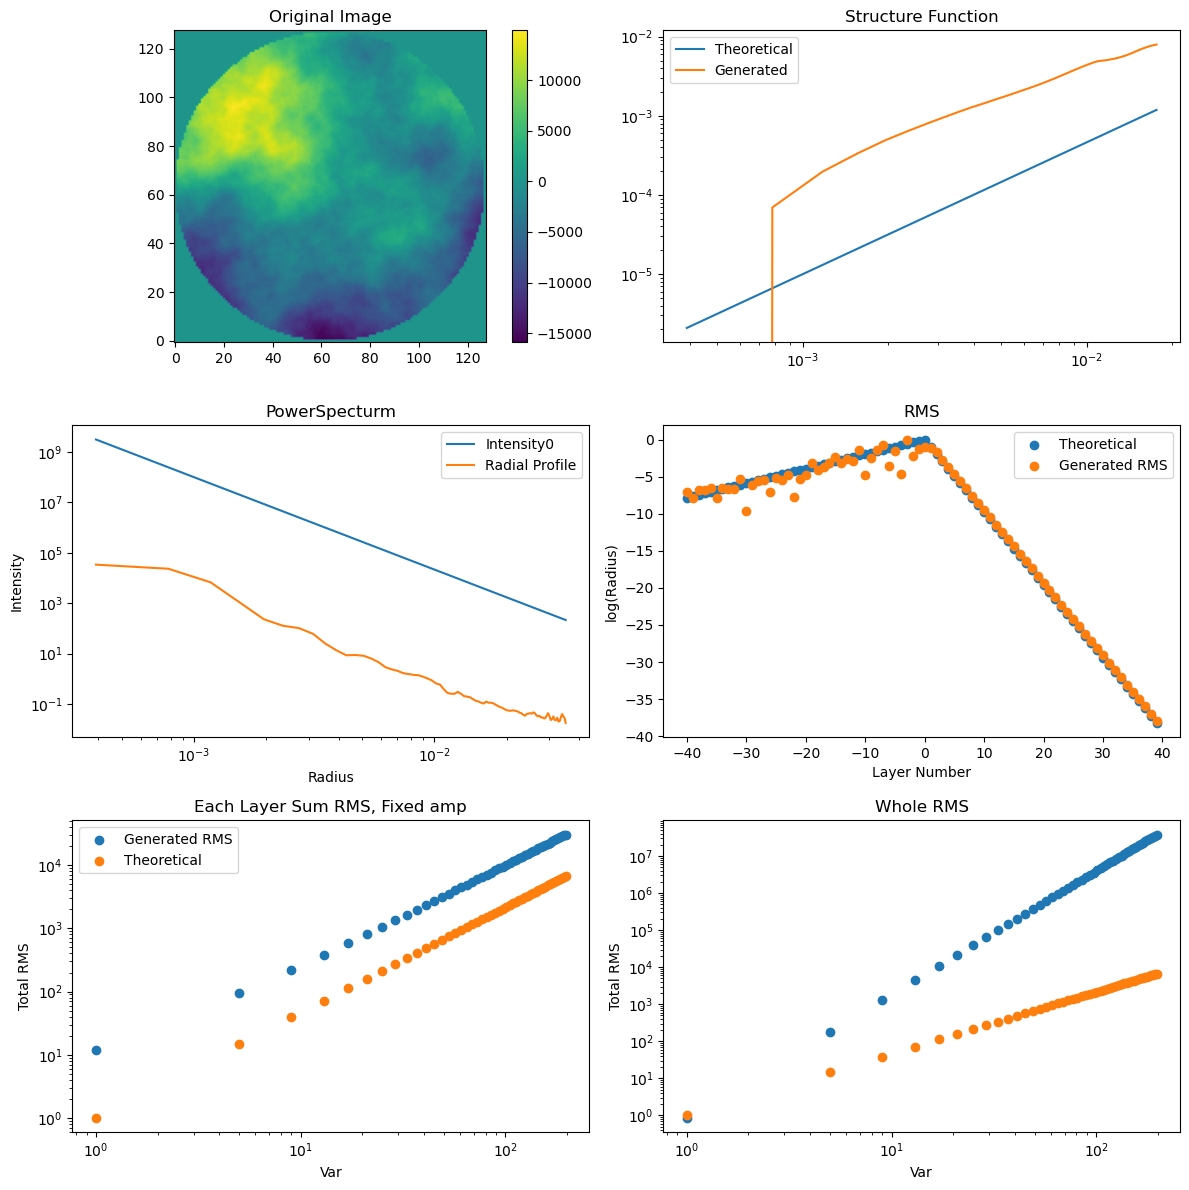

Noise Generation Time: 0.36 seconds
Power Spectrum Time: 0.00 seconds
Structure Function Time: 0.00 seconds
Total RMS Calculation Time: 11.25 seconds
Structure Function Average Time per Cycle: 0.02 seconds
         7248 function calls (7083 primitive calls) in 0.030 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       80    0.007    0.000    0.007    0.000 internals.py:70(_noise2a)
      646    0.006    0.000    0.006    0.000 {method 'reduce' of 'numpy.ufunc' objects}
      160    0.006    0.000    0.015    0.000 fromnumeric.py:3614(var)
        1    0.005    0.005    0.029    0.029 2859378405.py:32(Noise2Gen)
      160    0.002    0.000    0.009    0.000 _methods.py:198(_var)
        1    0.001    0.001    0.030    0.030 2859378405.py:305(run)
      163    0.000    0.000    0.001    0.000 stride_tricks.py:340(_broadcast_to)
      161    0.000    0.000    0.004    0.000 _methods.py:67(_count_reduce_items)
  332/167    0.

In [1]:
import numpy as np
import opensimplex as os
import matplotlib.pyplot as plt
import cProfile
import time

# Simulation Size and Parameter
class Sys:
    def __init__(self):
        self.Size = 128
        self.Radius = 0.05
        self.Number = 10
        self.Layer = 40
        self.Radius_max = 10
        self.r_0 = 0.1
        self.d_r_0 = 2 * self.Radius/self.r_0
        # self.amp = 10 ** (-np.log10(self.Radius) + 0.2456) # (It can correct for a fixed Radius)
        # # But variable radius will have wrong RMS value
        self.amp = 10 ** (0.4939)
        self.default_num = 100
        self.l = 1.8
        self.p = self.l ** (5.0/6.0)
        self.s = self.l ** (0)/ (2 * self.Radius)
        self.i = np.arange(-self.Layer, self.Layer) 
        self.ls = self.l ** self.i
        self.ps = self.p ** self.i
        self.rms = 1/self.ps ** 2
        self.rms[self.i < 0] *= self.ls[self.i < 0] ** 2


# Main Noise (Fixed Radius)
def Noise2Gen(x, y, sys):
    Radius = sys.Radius
    Size = sys.Size
    
    X, Y = np.meshgrid(x, y)
    circ = np.sqrt(X ** 2 + Y ** 2) < Radius
    
    # Parameter
    i = sys.i
    ls = sys.ls
    ps = sys.ps
    s = sys.s
    a = sys.amp
    rms = sys.rms
    r_0 = sys.r_0
    
    # Noise Generation
    P_all = []
    P = np.zeros((Size, Size))
    PP = np.zeros((Size, Size)) 
    P_rms = np.zeros_like(i, dtype=np.float64)
    P_rms0 = np.zeros_like(i, dtype=np.float64)
    
    for j in i:
        # P = a * os.noise2array(s * x * ls[j], s * y * ls[j] + np.random.rand() * 100) * circ / ps[j]
        P = a * os.noise2array(s * x * ls[j], s * y * ls[j] + j * 6.035) * circ / ps[j]
        P_rms0[j] = np.var(P, where = circ)
        P_rms[j] = np.var(P, where = circ)
        
        
        P_all.append(P)
        
    PP = np.sum(P_all, axis = 0)
    PP[circ] = PP[circ] - PP.mean(where=circ)
    PP *= 1.015 * (2 * Radius / r_0) ** (5/3) / np.sum(rms)
    P_rms *= 1.015 * (2 * Radius / r_0) ** (5/3) / np.sum(rms)
    
    return PP, P_rms, P_rms0, circ

# Power Spectrum, return the radial profile and radius
def NoisePowerSpectrum(P, Size):
    w = np.outer(np.blackman(Size), np.blackman(Size))
    Pfft = np.abs(np.fft.fftshift(np.fft.fft2(P * w))) ** 2
    
    Pfft_center = ((Size - 1)/2, (Size - 1)/2)
    row, col = Pfft.shape
    n, m = np.indices((row, col))
    r = np.sqrt((m - Pfft_center[1])**2 + (n - Pfft_center[0])**2)
    r = r.astype(np.int32)
    
    # Intensity Per Radius (Unit: 1)
    Pfft_meanr = np.bincount(r.ravel(), Pfft.ravel())
    nr = np.bincount(r.ravel())
    radial_profile = Pfft_meanr / nr
    
    return (radial_profile, r, nr)

# Structure Function
def StructrueFun(P, r, nr):
    P_meanr = np.bincount(r.ravel(), P.ravel())
    Nrefractive = P_meanr / nr
    max_lag = len(Nrefractive) // 2
    structure_func = np.zeros(max_lag)
    for l in range(1, max_lag):
        diff = np.abs(Nrefractive[l:] - Nrefractive[:-l]) ** 2
        structure_func[l] = np.mean(diff)
    return structure_func



# Noise, Power Spectrum
sys = Sys()

# For fixed Radius Calculation
Radius = sys.Radius
Size = sys.Size
Number = sys.Number
i = sys.i
l = sys.l
default_num = sys.default_num

x = np.linspace(-Radius, Radius, Size)
y = x


start_time = time.time()
P, P_RMS, P_RMS0, circnull = Noise2Gen(x, y, sys)
end_time = time.time()
noise_gen_time = end_time - start_time

start_time = time.time()
PowerSpec, r, nr = NoisePowerSpectrum(P, Size)
end_time = time.time()
power_spec_time = end_time - start_time

start_time = time.time()
StructF= StructrueFun(P, r, nr)
end_time = time.time()
struct_func_time = end_time - start_time

# Structure Function
ST = np.zeros(len(StructF))
start_time = time.time()
for mm in range(Number):
    P, RMSnull, Null, circnull = Noise2Gen(x, y, sys)
    StructF = StructrueFun(P, r, nr)
    ST += StructF
end_time = time.time()
struct_func_avg_time = (end_time - start_time) / Number

ST_mean = ST/Number


# # Amplitude Correction
# def Amp_Correct(P_rms, sys):
#     diff = np.log(sys.rms) - np.log(P_rms)
    
#     amp = 10 ** (diff)
#     return amp
# print(sys.amp,'a')
# sys.amp = Amp_Correct(P_RMS, sys)
# P_new, P_RMS_New, circnull = Noise2Gen(x, y, sys)
# print(sys.amp,'b')





# # s correction
# def s_correct(P_rms, sys):
#     l = sys.l
#     Layer = sys.Layer
#     diff = np.abs(-i - np.log(P_rms))
#     diff_ref = diff[-1]
#     Index = np.sum(diff > 2 * diff_ref)
#     s = l ** (1 - Index + Layer) / (2 * Radius)
#     return s

# sys.s = s_correct(P_rms, sys)
# P_new, P_rms_new, circnull = Noise2Gen(x, y, sys)


# Total RMS
Radius_max = sys.Radius_max
r_0 = sys.r_0

Radius_range = np.arange(0.05, Radius_max, 0.2)
d_r_0 = 2 * Radius_range/r_0
D_r_0 = d_r_0 ** (5/3)
PRMS = []
Total_PRMS = [] # Each Layer
Total_RMS = [] # Whole
start_time = time.time()


for nn in Radius_range:
    xx = np.linspace(-nn, nn, Size)
    yy = xx
    sys.Radius = nn
    sys.s = l ** (0)/ (2 * nn)
    # sys.amp = 10 ** (-np.log10(nn) + 0.2456) * nn
    # sys.amp = 10 ** (-np.log10(nn) + 1.13) * nn
    sys.amp = 10 ** (1.1267)
    s = sys.s
    
    
    
    # Calculate the mean value of RMS (Number) Time
    for mm in range(Number):
        P, P_rms, Null, circ = Noise2Gen(xx, yy, sys)  # (Not correct but close)
        PRMS.append(np.sum(P_rms)) # Each
        
        
        P_RMSAll = np.var(P, where = circ)
        
        # squared_P = np.square(P)
        # P_RMSAll = np.mean(squared_P) # Whole
        
    Total_RMS.append(P_RMSAll) # Whole
        
    PRMS_mean = np.mean(np.array(PRMS)) 
    Total_PRMS.append(PRMS_mean) # Each
    

end_time = time.time()
total_rms_time = end_time - start_time

Total_PRMS = np.array(Total_PRMS)
Total_RMS = np.array(Total_RMS)

# Reference
r0 = np.linspace(1, len(PowerSpec), len(PowerSpec)) * Radius / Size
rStruct = np.linspace(1, len(StructF), len(StructF)) * Radius / Size
Intensity0 = 10 ** (-3) * r0 ** (-11/3)
Structure0 = rStruct ** (5/3)
RMS0 = Radius_range ** (5/3)
D_r_0 = d_r_0 ** (5/3)

print(np.mean(P))



fig, axes = plt.subplots(3, 2, figsize=(12, 12))
# im1 = axes[0, 0].imshow(P, extent=(-Radius, Radius, -Radius, Radius), origin='lower', cmap='viridis', aspect='equal')
# axes[0, 0].set_title('Original Image')
im1 = axes[0, 0].imshow(P, origin='lower', cmap='viridis', aspect='equal')
axes[0, 0].set_title('Original Image')
fig.colorbar(im1, ax=axes[0, 0])

axes[0, 1].plot(rStruct, 10 ** (0) * Structure0, label='Theoretical')
axes[0, 1].plot(rStruct, ST_mean, label='Generated')
axes[0, 1].set_xscale('log')
axes[0, 1].set_yscale('log')
axes[0, 1].set_title('Structure Function')
axes[0, 1].legend()

axes[1, 0].plot(r0, Intensity0, label='Intensity0')
axes[1, 0].plot(r0, PowerSpec, label='Radial Profile')
axes[1, 0].set_xscale('log')
axes[1, 0].set_yscale('log')
axes[1, 0].set_xlabel('Radius')
axes[1, 0].set_ylabel('Intensity')
axes[1, 0].set_title('PowerSpecturm')
axes[1, 0].legend()

axes[1, 1].scatter(i, np.log(sys.rms), label='Theoretical')
axes[1, 1].scatter(i, np.log(P_RMS0), label='Generated RMS')
axes[1, 1].set_xlabel('Layer Number')
axes[1, 1].set_ylabel('log(Radius)')
axes[1, 1].set_title('RMS')
axes[1, 1].legend()

axes[2, 0].scatter(d_r_0, Total_PRMS,label='Generated RMS')
axes[2, 0].scatter(d_r_0, D_r_0, label='Theoretical')
axes[2, 0].set_xlabel('Var')
axes[2, 0].set_ylabel('Total RMS')
axes[2, 0].set_xscale('log')
axes[2, 0].set_yscale('log')
axes[2, 0].set_title('Each Layer Sum RMS, Fixed amp')
axes[2, 0].legend()

axes[2, 1].scatter(d_r_0, Total_RMS)
axes[2, 1].scatter(d_r_0, D_r_0)
axes[2, 1].set_xlabel('Var')
axes[2, 1].set_ylabel('Total RMS')
axes[2, 1].set_xscale('log')
axes[2, 1].set_yscale('log')
axes[2, 1].set_title('Whole RMS')

plt.tight_layout()
plt.show()



# Print operation times

print(f"Noise Generation Time: {noise_gen_time:.2f} seconds")
print(f"Power Spectrum Time: {power_spec_time:.2f} seconds")
print(f"Structure Function Time: {struct_func_time:.2f} seconds")
print(f"Total RMS Calculation Time: {total_rms_time:.2f} seconds")
print(f"Structure Function Average Time per Cycle: {struct_func_avg_time:.2f} seconds")



# Runtime & Benchmark
class Benchmark:
    def __init__(self):
        # Randomized coordinate arrays that will supply the noise funcs.
        rng = np.random.default_rng(seed=0)
        self.x = rng.random(default_num)
        self.y = rng.random(default_num)
        os.seed(0)

    def run(self):
        # This is the simplest way of generating a small amount of noise values.
        # for i in range(default_num):
        # 	self.simplex.noise2d(self.x[i], self.y[i])
        # 	self.simplex.noise3d(self.x[i], self.y[i], self.z[i])
        # 	self.simplex.noise4d(self.x[i], self.y[i], self.z[i], self.w[i])

        # The most performant way of generating a large number of noise values is by
        # creating a numpy array with your coordinates and use these versions of the
        # noise funcs, as they are optimized for arrays.
        Noise2Gen(self.x, self.y, sys)
    
c = Benchmark()
cProfile.run("c.run()", sort="tottime")  





0.2801458747743772


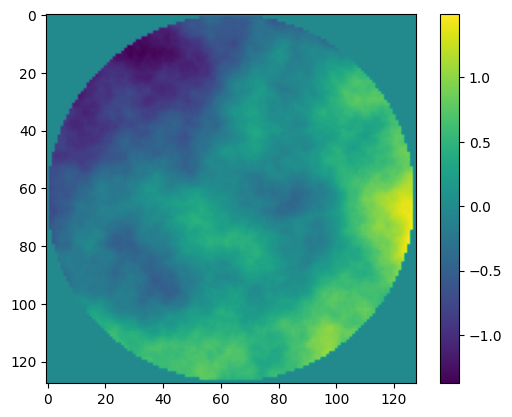

In [10]:
import numpy as np
import opensimplex as os
import matplotlib.pyplot as plt
import cProfile
import time

# Simulation Size and Parameter
class Sys:
    def __init__(self):
        self.Size = 128
        self.Radius = 0.05
        self.Number = 1
        self.Layer = 10
        self.Radius_max = 10
        self.r_0 = 0.1
        self.d_r_0 = 1
        # self.amp = 10 ** (-np.log10(self.Radius) + 0.2456) # (It can correct for a fixed Radius)
        # # But variable radius will have wrong RMS value
        self.amp = 10 ** (0.4939)
        self.default_num = 100
        self.l = 1.8
        self.p = self.l ** (5.0/6.0)
        self.s = 1
        self.i = np.arange(-self.Layer, self.Layer) 
        self.ls = self.l ** self.i
        self.ps = self.p ** self.i
        self.rms = 1/self.ps ** 2
        self.rms[self.i < 0] *= self.ls[self.i < 0] ** 2


# Main Noise (Fixed Radius)
def Noise2Gen(sys):
    Radius = sys.Radius
    Size = sys.Size
    r_0 = sys.r_0
    
    x = np.linspace(-0.5, 0.5, Size)
    y = x
    X, Y = np.meshgrid(x, y)
    circ = np.sqrt(X ** 2 + Y ** 2) < 0.5
    
    # Parameter
    i = sys.i
    ls = sys.ls
    ps = sys.ps
    s = sys.s
    a = sys.amp
    rms = sys.rms
    
    # Noise Generation
    P = np.zeros((Size, Size))
    P_rms = np.zeros_like(i, dtype=np.float64)
    P_rms0 = np.zeros_like(i, dtype=np.float64)
    t = 100
    
    for j in i:
        if j <= 0:
            P += a * os.noise2array(s * x * ls[j], s * (y + t * 0.01) * ls[j] + j * 6.03) * circ / ps[j]
        else:
            P += a * os.noise2array(s * x * ls[j], s * y * ls[j] + j * 6.03) * circ
        
        P_rms[j] = np.var(P, where = circ)
        
        
    P[circ] = P[circ] - P.mean(where=circ)
    
    
    P *= 1.03 * (2 * Radius / r_0) ** (5/6) / np.sqrt(np.sum(rms))
    P_rms *= 1.015 * (2 * Radius / r_0) ** (5/3) / np.sum(rms)
 
    return P, P_rms, circ

sys = Sys()
P, P_RMS, circ = Noise2Gen(sys)


RMS = np.var(P, where = circ)
plt.imshow(P)
plt.colorbar()


print(RMS)

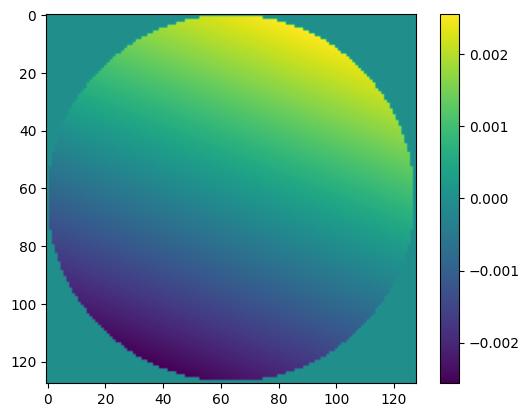

In [49]:
x = np.linspace(-0.5, 0.5, 128)
y = x
X, Y = np.meshgrid(x, y)
circ = np.sqrt(X ** 2 + Y ** 2) < 0.5
l = 1 / 357
noise = os.noise2array(l * x, l * y) * circ
plt.imshow(noise)
plt.colorbar()